# Verifying the EKF code with a Toy Example

In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt

# Get environment variables
import os
import sys

sys.path.append("..")  # Add the parent directory of notebooks to sys.path

from lac.utils.plotting import pose_traces
from lac.localization.ekf import EKF
from lac.localization.imu_dynamics import *

import apriltag
from scipy.spatial.transform import Rotation

import lac.params as params
from lac.utils.frames import (
    apply_transform,
    invert_transform_mat,
    get_cam_pose_rover,
    OPENCV_TO_CAMERA_PASSIVE,
)
from lac.perception.vision import FiducialLocalizer
from lac.utils.visualization import overlay_tag_detections

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load IMU and Ground Truth Measurement Data

In [ ]:
data_dir = "../../output/lander_fiducials_right_light/"
data_path = data_dir + "data_log.json"
json_data = json.load(open(f"{data_path}"))

poses = []
imu_data = []

for frame in json_data["frames"]:
    poses.append(np.array(frame["pose"]))
    imu_data.append(np.array(frame["imu"]))

imu_data = np.array(imu_data)

print(imu_data.shape)

(6400, 6)


In [13]:
from scipy.spatial.transform import Rotation
from lac.util import skew_symmetric, normalize_rotation_matrix

gt_rotations_euler = np.zeros((len(poses), 3))
imu_rotations_euler = np.zeros((len(poses), 3))

for i in range(len(poses)):
    gt_rotations_euler[i] = Rotation.from_matrix(poses[i][:3, :3]).as_euler("xyz", degrees=False)

gt_translations = np.zeros((len(poses), 6))
for i in range(len(poses)):
    gt_translations[i, :3] = poses[i][:3, 3]
    if i > 0:
        dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
        gt_translations[i, 3:] = (gt_translations[i, :3] - gt_translations[i - 1, :3]) / dt

## Load AprilTag Data

In [14]:
fid_localizer = FiducialLocalizer()

data_path = os.path.expanduser("../../output/lander_fiducials_right_light")
json_data = json.load(open(f"{data_path}/data_log.json"))
lander_pose = np.array(json_data["lander_pose_world"])
poses = np.array([frame["pose"] for frame in json_data["frames"]])

## Toy Measurement Model

In [15]:
from lac.perception.pnp import get_tag_corners_world, solve_tag_pnp
import cv2 as cv

def pose_to_state(pose):
    t = pose[:3, 3]
    Rot = pose[:3, :3]
    euler = Rotation.from_matrix(Rot).as_euler("xyz", degrees=False)
    return np.concatenate([t, euler])

def show_detection(i, CAM_NAME):
    fig = plt.figure(figsize=(6, 3))
    img = cv.imread(os.path.join(data_path, CAM_NAME, f"{i}.png"), cv.IMREAD_GRAYSCALE)
    detections = fid_localizer.detect(img)
    overlay = overlay_tag_detections(img, detections)
    plt.imshow(overlay)
    plt.show()


### Run Examples

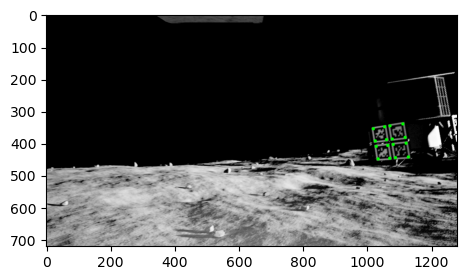

True pose:
[-9.25453758  2.83825302  1.88423133  0.09285791 -0.07827269  0.18526678]
 
Estimated pose:
[-9.41091306  2.58058668  1.88432397  0.09089992 -0.07820197  0.21801164]
[-9.35963755  2.6353444   1.87339348  0.09047323 -0.07869949  0.21201465]
[-9.41981126  2.58009054  1.79423669  0.08253061 -0.08461149  0.218293  ]
[-9.32518086  2.63874619  1.79893424  0.08577715 -0.08549012  0.21057083]
 
Mean Est Pose:
[-9.37888569  2.60869195  1.83772209  0.08742023 -0.08175077  0.21472253]
 
(True - Estimated Mean):
[-0.1243481  -0.22956107 -0.04650923 -0.00543769 -0.00347807  0.02945575]
 
Estimated Sigma:
[0.03858547 0.02837938 0.04135112 0.00346544 0.00331929 0.003469  ]


In [16]:
# case 1
i = 63
CAM_NAME = "front left"
show_detection(i, CAM_NAME)
img = cv.imread(os.path.join(data_path, CAM_NAME, f"{i}.png"), cv.IMREAD_GRAYSCALE)
poses_ests = fid_localizer.estimate_rover_pose(img, CAM_NAME, lander_pose)
pose_true = pose_to_state(poses[i])

print("True pose:")
print(pose_true)

print(" ")
print("Estimated pose:")
diffs = np.zeros((len(poses_ests), 6))
pose_est_array = np.zeros((len(poses_ests), 6))
for k, pose_est in enumerate(poses_ests):
    print(pose_to_state(pose_est))
    diffs[k] = pose_to_state(pose_est) - pose_true
    pose_est_array[k] = pose_to_state(pose_est)

print(" ")
print("Mean Est Pose:")
mean_est = np.mean(pose_est_array, axis=0)
print(mean_est)

print(" ")
print("(True - Estimated Mean):")
print(mean_est - pose_true)

print(" ")
print("Estimated Sigma:")
meanpose = np.mean(pose_est_array, axis=0)
print(np.std(pose_est_array, axis=0))


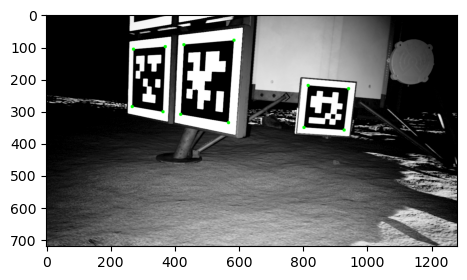

True pose:
[ 0.59474552  2.64076567  1.57105362  0.09677312  0.07720709 -0.07198067]
 
Estimated pose:
[ 0.58989028  2.66519328  1.57033629  0.09740829  0.07690115 -0.06789818]
[ 0.56790417  2.66849183  1.57452716  0.09794631  0.0779225  -0.06119987]
[ 0.64717238  2.66722687  1.57150682  0.09506536  0.07673335 -0.09150354]
 
Mean Est Pose:
[ 0.60165561  2.66697066  1.57212342  0.09680665  0.07718567 -0.07353387]
 
(True - Estimated Mean):
[ 6.91009521e-03  2.62049957e-02  1.06979774e-03  3.35375761e-05
 -2.14208556e-05 -1.55319940e-03]
 
Estimated Sigma:
[0.03341337 0.00135876 0.00176559 0.00125072 0.0005255  0.01299741]


In [17]:
# case 2
i=1759
CAM_NAME="right"

show_detection(i, CAM_NAME)
img = cv.imread(os.path.join(data_path, CAM_NAME, f"{i}.png"), cv.IMREAD_GRAYSCALE)
poses_ests = fid_localizer.estimate_rover_pose(img, CAM_NAME, lander_pose)
pose_true = pose_to_state(poses[i])

print("True pose:")
print(pose_true)

print(" ")
print("Estimated pose:")
diffs = np.zeros((len(poses_ests), 6))
pose_est_array = np.zeros((len(poses_ests), 6))
for k, pose_est in enumerate(poses_ests):
    print(pose_to_state(pose_est))
    diffs[k] = pose_to_state(pose_est) - pose_true
    pose_est_array[k] = pose_to_state(pose_est)

print(" ")
print("Mean Est Pose:")
mean_est = np.mean(pose_est_array, axis=0)
print(mean_est)

print(" ")
print("(True - Estimated Mean):")
print(mean_est - pose_true)

print(" ")
print("Estimated Sigma:")
meanpose = np.mean(pose_est_array, axis=0)
print(np.std(pose_est_array, axis=0))

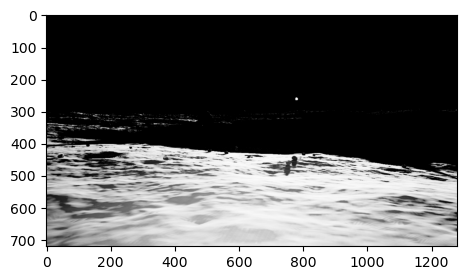

True pose:
[[ 0.96528909 -0.25711218  0.04593795 -9.38802528]
 [ 0.25999057  0.96269305 -0.0750133   2.85148883]
 [-0.02493731  0.08435295  0.99612384  1.86426353]
 [ 0.          0.          0.          1.        ]]
Estimated pose:


In [18]:
# case 3
i=1
CAM_NAME="right"

show_detection(i, CAM_NAME)
img = cv.imread(os.path.join(data_path, CAM_NAME, f"{i}.png"), cv.IMREAD_GRAYSCALE)
poses_ests = fid_localizer.estimate_rover_pose(img, CAM_NAME, lander_pose)
pose_true = poses[i]

print("True pose:")
print(pose_true)
print("Estimated pose:")
for pose_est in poses_ests:
    print(pose_est)
    

## Characterize the Fiduciual Pointing Error

In [19]:
def compute_pose_est_error(i, CAM_NAME, poses, lander_pose, rover_to_cam, cam_to_rover):

    fid_localizer = FiducialLocalizer()
    data_path = os.path.expanduser("../../output/lander_fiducials_right_light")
    img = cv.imread(os.path.join(data_path, CAM_NAME, f"{i}.png"), cv.IMREAD_GRAYSCALE)

    cam_pose_ests = []
    rover_pose_ests = []
    diffs_cam = np.zeros((0, 6))
    diffs_rover = np.zeros((0, 6))

    if img is None:
        return i, diffs_cam, diffs_rover, cam_pose_ests, rover_pose_ests

    detections = fid_localizer.detect(img)
    cam_pose_ests = solve_tag_pnp(detections, lander_pose)
    diffs_cam = np.zeros((len(cam_pose_ests), 6))
    diffs_rover = np.zeros((len(cam_pose_ests), 6))

    if len(cam_pose_ests) > 0:
        rover_pose_true = pose_to_state(poses[i])
        cam_pose_true = pose_to_state(poses[i] @ rover_to_cam)

        for k, pose_est_cam_mat in enumerate(cam_pose_ests):
            pose_est_cam = pose_to_state(pose_est_cam_mat)
            diffs_cam[k] = pose_est_cam - cam_pose_true

            pose_est_rover = pose_est_cam_mat @ cam_to_rover
            diffs_rover[k] = pose_to_state(pose_est_rover) - rover_pose_true

            rover_pose_ests.append(pose_est_rover)

    return i, diffs_cam, diffs_rover, cam_pose_ests, rover_pose_ests

In [ ]:
from tqdm import tqdm
from joblib import Parallel, delayed
from lac.utils.frames import invert_transform_mat

# surpress warnings
import warnings
warnings.filterwarnings("ignore")

log_file = data_dir + "pose_estimation_errors.pkl"

poses = []

for frame in json_data["frames"]:
    poses.append(np.array(frame["pose"]))

cameras = ["front left", "right"]
n_frames = len(json_data["frames"])

diff_arrays_cam = {}
diff_arrays_rover = {}
cam_pose_ests_store = {"front left" : {}, "right" : {}}
rover_pose_ests_store = {"front left" : {}, "right" : {}}

use_parallel = True

if os.path.exists(log_file):
    with open(log_file, "rb") as f:
        diff_arrays_cam, diff_arrays_rover, cam_pose_ests_store, rover_pose_ests_store = pickle.load(f)
else:
    for CAM_NAME in cameras:
        rover_to_cam = get_cam_pose_rover(CAM_NAME)
        cam_to_rover = invert_transform_mat(rover_to_cam)

        if use_parallel:
            results = Parallel(n_jobs=-1)(
                    delayed(compute_pose_est_error)(i, CAM_NAME, poses, lander_pose, rover_to_cam, cam_to_rover) 
                    for i in tqdm(range(1, n_frames+1, 2), desc="Computing pose estimation errors")
                )
        else:
            results = []
            for i in tqdm(range(1, n_frames+1, 2), desc="Computing pose estimation errors"):
                results.append(compute_pose_est_error(i, CAM_NAME, poses, lander_pose, rover_to_cam, cam_to_rover))
        
        # set results 
        diff_array_cam = np.zeros((0, 6))
        diff_array_rover = np.zeros((0, 6))

        for i, diffs_cam, diffs_rover, cam_pose_ests, rover_pose_ests in results:
            diff_array_cam = np.vstack([diff_array_cam, diffs_cam])
            diff_array_rover = np.vstack([diff_array_rover, diffs_rover])
            cam_pose_ests_store[CAM_NAME][i] = cam_pose_ests
            rover_pose_ests_store[CAM_NAME][i] = rover_pose_ests

        diff_arrays_cam[CAM_NAME] = diff_array_cam
        diff_arrays_rover[CAM_NAME] = diff_array_rover

Computing pose estimation errors:   2%|▏         | 72/3200 [00:13<08:26,  6.17it/s]/private/var/folders/1f/_8g3y5td38n93nph4z3c5d4c0000gn/T/pip-install-zootlbfx/apriltag_abd51024bf894947b8c4bddddffc71fe/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/private/var/folders/1f/_8g3y5td38n93nph4z3c5d4c0000gn/T/pip-install-zootlbfx/apriltag_abd51024bf894947b8c4bddddffc71fe/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
Computing pose estimation errors:   3%|▎         | 108/3200 [00:20<08:41,  5.93it/s]/private/var/folders/1f/_8g3y5td38n93nph4z3c5d4c0000gn/T/pip-install-zootlbfx/apriltag_abd51024bf894947b8c4bddddffc71fe/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/private/var/folders/1f/_8g3y5td38n93nph4z3c5d4c0000gn/T/pip-install-zootlbfx/apriltag_abd51024bf894947b8c4bddddffc71fe/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
Computing pose estimation errors:   4%|▍         | 132/3200 [00:26<09:39,  5.29it/s]/private/var/

In [ ]:
# save results
import pickle

log_file = data_dir + "pose_estimation_errors.pkl"
with open(log_file, "wb") as f:
    pickle.dump(
        {
            "diff_arrays_cam": diff_arrays_cam,
            "diff_arrays_rover": diff_arrays_rover,
            "cam_pose_ests_store": cam_pose_ests,
            "rover_pose_ests_store": rover_pose_ests,
        },
        f,
    )

In [ ]:
# plot histogram
diff_arrays_list= [diff_arrays_cam, diff_arrays_rover]
diff_array_label = ["Camera", "Rover"]

for j, diff_arrays in enumerate(diff_arrays_list):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("Pose Estimation Error Histograms: {}".format(diff_array_label[j]))
    labels = ["x [m]", "y [m]", "z [m]", "roll [rad]", "pitch [rad]", "yaw [rad]"]
    colors = {"front left": "b", "right": "r"}

    for cam in cameras:
        diff_array = diff_arrays[cam]
        print(diff_array.shape)
        for i in range(6):
            if i < 3:
                bins = np.linspace(-0.5, 0.5, 100)
            else:
                bins = np.linspace(-0.1, 0.1, 100)
            ax[i//3, i%3].hist(diff_array[:, i], bins=bins, alpha=0.2, label=cam, color=colors[cam])
            ax[i//3, i%3].set_title(labels[i])
            ax[i//3, i%3].set_xlabel("Error")
            ax[i//3, i%3].set_ylabel("Frequency")
            # compute mean
            mean = np.mean(diff_array[:, i])
            std = np.std(diff_array[:, i])

            ax[i//3, i%3].axvline(mean, color=colors[cam], linestyle='dashed', linewidth=1)
            # ax[i//3, i%3].axvline(mean + std, color=colors[cam], linestyle='dashed', linewidth=1)
            # ax[i//3, i%3].axvline(mean - std, color=colors[cam], linestyle='dashed', linewidth=1)

            print("Camera: ", cam, "Label: ", labels[i], "Mean: ", mean, "Std: ", std)

    plt.tight_layout()
    plt.legend()
    plt.show()

## Measurement Model

In [ ]:
def get_pose_measurement_tag(x, nmeas):
    """
    Generate a measurement vector and the corresponding Jacobian and covariance matrix

    Args:
    x: state vector (9x1)  [x, y, z, vx, vy, vz, roll, pitch, yaw]
    nmeas: number of measurements (detected tags)
    """

    H = np.zeros((0, 9))
    Rdiag = np.zeros((0))

    meas = np.zeros(6 * nmeas)

    for j in range(nmeas):

        meas[6*j:6*j + 3] = x[:3]
        meas[6*j + 3:6*j + 6] = x[6:]

        # Jacobian of the measurement function
        Htmp = np.zeros((6, 9))
        Htmp[:3, :3] = np.eye(3)
        Htmp[3:, 6:] = np.eye(3)

        H = np.vstack([H, Htmp])

        std_x = 0.25
        std_y = 0.25
        std_z = 0.25
        std_roll = 0.05
        std_pitch = 0.05
        std_yaw = 0.2

        Rtmp = np.array([std_x**2, std_y**2, std_z**2, std_roll**2, std_pitch**2, std_yaw**2])
        Rdiag = np.concatenate([Rdiag, Rtmp])

    R = np.diag(Rdiag)

    return meas, H, R

## Post-Processing Functions

In [ ]:
def plot_results(data, title=""):
    times = data["times"]
    xerr = data["x_err"]
    P_store = data["P_store"]

    fig, axes = plt.subplots(3, 3, figsize=(15, 10))

    n_sim = xerr.shape[0]

    # positions -------------------------------
    pos_labels = ["X", "Y", "Z", "Vx", "Vy", "Vz"]

    for i in range(6):
        ax = axes.flatten()[i]

        ax.plot(times, xerr[:, i], label="True")
        # plot 3-sigma bounds
        ax.fill_between(
            times,
            - 3 * np.sqrt(P_store[:, i, i]),
            + 3 * np.sqrt(P_store[:, i, i]),
            alpha=0.2,
            label="3-sigma bound"
        )

        ax.legend()
        ax.grid()
        ax.set_xlabel("Time")
        ax.set_ylabel(f"{pos_labels[i]}")

    # angles -----------------------------
    RAD2DEG = 180 / np.pi
    pos_labels = ["Err Roll (deg)", "Err Pitch (deg)", "Err Yaw (deg)"]
    for i in range(3):
        ax = axes.flatten()[i + 6]
        ax.plot(times, xerr[:, i+6] * RAD2DEG, label="True")
        # plot 3-sigma bounds
        ax.fill_between(
            times,
            - 3 * np.sqrt(P_store[:, 6+i, 6+i]) * RAD2DEG,
            + 3 * np.sqrt(P_store[:, 6+i, 6+i]) * RAD2DEG,
            alpha=0.2,
            label="3-sigma bounds"
        )
        ax.legend()
        ax.grid()
        ax.set_xlabel("Time")
        ax.set_ylabel(f"{pos_labels[i]}")
        ax.set_ylim(-1, 1)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Run EKF Model 

In [ ]:
print(rover_pose_ests_store.keys())
print(rover_pose_ests_store["right"].keys())
meas_idxs = list(rover_pose_ests_store["right"].keys())

print(5 in meas_idxs)

In [ ]:
# Get Initial states
R_0 = poses[0][:3, :3]

imu_rotations = []
imu_rotations.append(R_0)

v0 = np.zeros(3)
# v0 = (gt_translations[1, :3] - gt_translations[0, :3]) / (json_data["frames"][1]["mission_time"] - json_data["frames"][0]["mission_time"])

x0 = np.hstack((gt_translations[0, :3], v0, gt_rotations_euler[0])).T

print("r0 :", gt_translations[0, :3])
print("v0 :", v0)
print("angle0 :", gt_rotations_euler[0])

init_r = 0.001
init_v = 0.01
init_angle = 0.001
P0 = np.diag(np.hstack((np.ones(3) * init_r * init_r, np.ones(3) * init_v * init_v, np.ones(3) * init_angle * init_angle)))

# Process noise
def create_Q(sigma_a, sigma_angle):
    dt2 = dt * dt
    dt3 = dt2 * dt
    Q_rvm = np.block([
        [np.eye(3) * dt3/3.0, np.eye(3) * dt2/2.0],
        [np.eye(3) * dt2/2.0, np.eye(3) *dt]
    ]
    ) * (sigma_a ** 2)

    Q_angle = np.eye(3) * sigma_angle ** 2

    Q_meas = np.block([
        [Q_rvm, np.zeros((6, 3))],
        [np.zeros((3, 6)), Q_angle]
    ])

    return Q_meas


Q_imu = create_Q(0.00, 0.00005)
Q_meas = create_Q(0.03, 0.00005)


ekfi = EKF(x0, P0, store=False)  # EKF with IMU-only
ekfm = EKF(x0, P0, store=True)  # EKF with IMU + Measurement

n_sim = len(poses)
# n_sim = 1000

x_store_imu = np.zeros((n_sim, 9))
P_store_imu = np.zeros((n_sim, 9, 9))
x_store_meas = np.zeros((n_sim, 9))
P_store_meas = np.zeros((n_sim, 9, 9))
true_states = np.zeros((n_sim, 9))

x_store_imu[0] = ekfi.x
P_store_imu[0] = ekfi.P
x_store_meas[0] = ekfm.x
P_store_meas[0] = ekfm.P

time = 0
times = [0]
meas_tidx = []

true_states[0] = np.hstack((
    gt_translations[0, :3],
    (gt_translations[1, :3] - gt_translations[0, :3]) / dt,
    gt_rotations_euler[0]
))

meas_inv = 2   # measurement interval
cameras = ["front left", "right"]

# Generate true measurements ----------------------------------------
true_meas = {}
n_meas = {}

for i in range(1, n_sim):

    # true rover pose
    true_rover_state = np.hstack((
        gt_translations[i, :3],
        (gt_translations[i, :3] - gt_translations[i - 1, :3]) / dt,
        gt_rotations_euler[i]
    ))

    true_states[i] = true_rover_state

    # sample image every 1 sec
    if (i in meas_idxs):
        # measurement ----------------------------------------
        meas_pose = rover_pose_ests_store["right"][i]
        true_meas_list = [pose_to_state(pose) for pose in meas_pose]
        true_meas_array = np.array(true_meas_list).flatten()
        true_meas[i] = true_meas_array
        n_meas[i] = len(meas_pose)

# Run EKF
for i in range(1, n_sim):
    # dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
    dt = 1/20
    time += dt
    times.append(time)

    a_k = imu_data[i][:3]
    omega_k = imu_data[i][3:]

    dyn_func = lambda x: propagate_state(x, a_k, omega_k, dt, with_stm=True, use_numdiff=False)

    ekfi.predict(i, dyn_func, Q_imu)
    ekfm.predict(i, dyn_func, Q_meas)

    # sample image every 1 sec
    if (i in meas_idxs):
        # measurement ----------------------------------------
        if n_meas[i] > 0:
            meas_func = lambda x: get_pose_measurement_tag(x, n_meas[i])                        
            ekfm.update(i, true_meas[i], meas_func)

        # Compute error
        error = ekfm.x - true_rover_state

        print("Time: {:.2f} s |  x_err: {:.3f} m | y_err: {:.3f} m | z_err: {:.3f} m | roll_err: {:.3f} deg | pitch_err: {:.3f} deg | yaw_err: {:.3f} deg".format(
            time,
            error[0], error[1], error[2],
            error[6] * 180 / np.pi, error[7] * 180 / np.pi, error[8] * 180 / np.pi
        ))

        meas_tidx.append(i)

    x_store_imu[i] = ekfi.x
    P_store_imu[i] = ekfi.P
    x_store_meas[i] = ekfm.x
    P_store_meas[i] = ekfm.P

# smooth
rms_error = np.sqrt(np.mean((x_store_meas[:, :3] - true_states[:, :3]) ** 2, axis=0))
print(f"EKF | RMS Position Error: {rms_error}")

# run smoother
ekfm.smooth()

# run iterations 
n_iter = 3
for itr in range(n_iter):
    # Compute the rms position error
    res = ekfm.get_array()
    rms_err = np.sqrt(np.mean((res["xhat_smooth"][:, :3] - true_states[:, :3]) ** 2, axis=0))

    print(f"Iteration {itr+1} | RMS Position Error: {rms_err}")

    ekfm = EKF(ekfm.xhat_store_smooth[0], P0, store=True)  # EKF with IMU + Measurement

    for i in range(1, n_sim):
        a_k = imu_data[i][:3]
        omega_k = imu_data[i][3:]

        dyn_func = lambda x: propagate_state(x, a_k, omega_k, dt, with_stm=True, use_numdiff=False)
        ekfm.predict(i, dyn_func, Q_meas)

        # sample image every 1 sec
        if (i in meas_idxs):
            # measurement ----------------------------------------
            if n_meas[i] > 0:
                meas_func = lambda x: get_pose_measurement_tag(x, n_meas[i])                                       
                ekfm.update(i, true_meas[i], meas_func)

    # run smoother
    ekfm.smooth()

res = ekfm.get_array()

data_imu = {'times': times, 'x_err': x_store_imu - true_states, 'P_store': P_store_imu}
data_meas = {'times': times, 'x_err': x_store_meas - true_states, 'P_store': P_store_meas}  
data_smooth = {'times': times, 'x_err': res["xhat_smooth"] - true_states, 'P_store': res["Phat_smooth"]}

rms_pos = {}
rms_angle = {}

rms_pos["imu"] = np.sqrt(np.mean(data_imu["x_err"][:, :3] ** 2, axis=0))
rms_pos["meas"] = np.sqrt(np.mean(data_meas["x_err"][:, :3] ** 2, axis=0))
rms_pos["smooth"] = np.sqrt(np.mean(data_smooth["x_err"][:, :3] ** 2, axis=0))

rms_angle["imu"] = np.sqrt(np.mean(data_imu["x_err"][:, 6:] ** 2, axis=0))
rms_angle["meas"] = np.sqrt(np.mean(data_meas["x_err"][:, 6:] ** 2, axis=0))
rms_angle["smooth"] = np.sqrt(np.mean(data_smooth["x_err"][:, 6:] ** 2, axis=0))

## Plot the IMU-only result

In [ ]:
print("IMU RMS Pos: ", rms_pos["imu"])
print("IMU RMS Angle: ", rms_angle["imu"])

plot_results(data_imu, title="IMU Only")

### Plot IMU + Measureent Result

In [ ]:
print("Measurement RMS Pos: ", rms_pos["meas"])
print("Measurement RMS Angle: ", rms_angle["meas"])

plot_results(data_meas, title="IMU + Measurement")

### Smoothing

In [ ]:
print("Smoothed RMS Pos: ", rms_pos["smooth"])
print("Smoothed RMS Angle: ", rms_angle["smooth"])

plot_results(data_smooth, title="Smoothed")

## Plot Trajectory

In [ ]:
from lac.utils.plotting import plot_path_3d, plot_3d_points

lander_position = lander_pose[:3, 3]



fig = plot_path_3d(
    gt_translations,
    color="blue",
    name="Ground truth",
)
fig = plot_3d_points(
    lander_position[None, :], fig=fig, color="red", markersize=3, name="Lander Origin"
)
# fig = plot_path_3d(
#     x_store_imu[:, :3],
#     fig=fig,
#     color="orange",
#     name="EKF with IMU",
# )
fig = plot_path_3d(
    x_store_meas[:, :3],
    fig=fig,
    color="green",
    name="EKF with Measurements",
)
fig = plot_path_3d(
    res["xhat_smooth"][:, :3],
    fig=fig,
    color="purple",
    name="Smoothed",
)

true_meas_array = np.array(list(true_meas.values()))
fig = plot_3d_points(
    true_meas_array[:, :3],
    fig=fig,
    color="red",
    markersize=3,
    name="True Measurements"
)


fig.update_layout(height=700, width=1200, scene_aspectmode="data")
fig.show()